<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/QAOA_depth4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
!pip install pennylane
!pip install qulacs pennylane-qulacs
!pip install seaborn
!pip install lightning

In [ ]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
import pennylane as qml

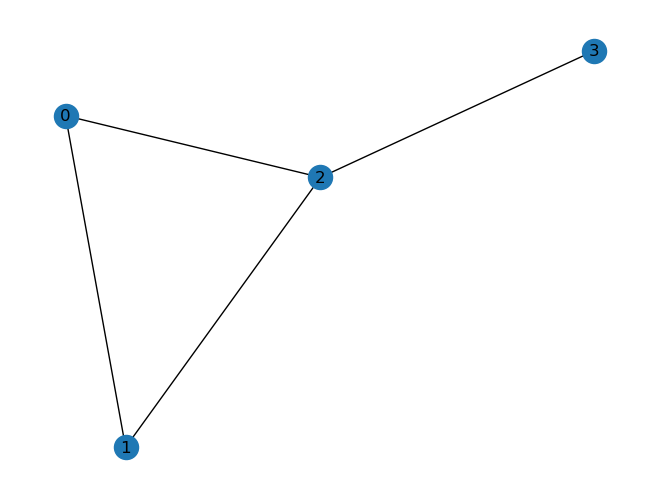

In [ ]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [ ]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [ ]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [ ]:
wires = range(4)
depth = 4

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [ ]:
#dev = qml.device("qulacs.simulator", wires=wires)
dev = qml.device("default.qubit", wires=wires)
#dev = qml.device("lightning.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

def quality_ratio(params):
    probs = probability_circuit(params[0], params[1])
    return probs[6]+probs[10]

def asymmetry_ratio(params):
    probs = probability_circuit(params[0], params[1])
    return probs[6]/probs[10]

In [ ]:
seed_value = 947612
step_size = 0.1
cost_tolerance = 0.01
cost_tolerance_count = 6
init_count = 1000
steps = 300

In [ ]:
init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    gam = np.random.random(depth)
    alp = np.random.random(depth)
    init_params_array.append(np.array([gam, alp], requires_grad=True))
    #init_params_array.append(np.array([[np.random.random(1), np.random.random(1), np.random.random(1)], [np.random.random(1), np.random.random(1), np.random.random(1)]], requires_grad=True))

In [ ]:
def calc_plot_data(params_array):
    opt_costs = []
    opt_quality = []
    opt_asym = []
    for params in params_array:
        opt_costs.append(cost_function(params))
        opt_quality.append(quality_ratio(params))
        opt_asym.append(asymmetry_ratio(params))
    return (opt_costs,opt_quality,opt_asym)

In [ ]:
def plot_opt_data(opt_costs,opt_quality,opt_title):
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=False)

    # We can set the number of bins with the *bins* keyword argument.
    n_bins = 10
    quality_bins = [i*0.02 for i in range(50)]
    cost_bins = [-2.5+i*0.04 for i in range(50)]
    axs[0].hist(opt_costs, bins=cost_bins)
    axs[1].hist(opt_quality, bins=quality_bins)
    axs[2].scatter(opt_costs,opt_quality)
    axs[0].set_xlabel("optimized cost")
    axs[0].set_ylabel("count")
    axs[1].set_xlabel("quality ratio")
    axs[1].set_ylabel("count")
    axs[0].set_title(opt_title)
    axs[1].set_title(opt_title)
    axs[2].set_xlabel("optimized cost")
    axs[2].set_ylabel("quality ratio")
    plt.show()

In [ ]:
qng_opt_params = []
for init_params in tqdm(init_params_array):
    optimizer = qml.QNGOptimizer(stepsize = step_size)
    params = init_params
    best_cost = 100
    cost_counter = 0
    for i in range(steps):
        params = optimizer.step(cost_function, params)
        cur_cost = cost_function(params)
        if(abs(best_cost - cur_cost) < cost_tolerance):
            cost_counter += 1
            if(cost_counter > cost_tolerance_count):
                break
        else:
            cost_counter = 0
        if(best_cost > cur_cost):
            best_cost = cur_cost
    qng_opt_params.append(params)

100%|██████████| 1000/1000 [6:54:36<00:00, 24.88s/it]     


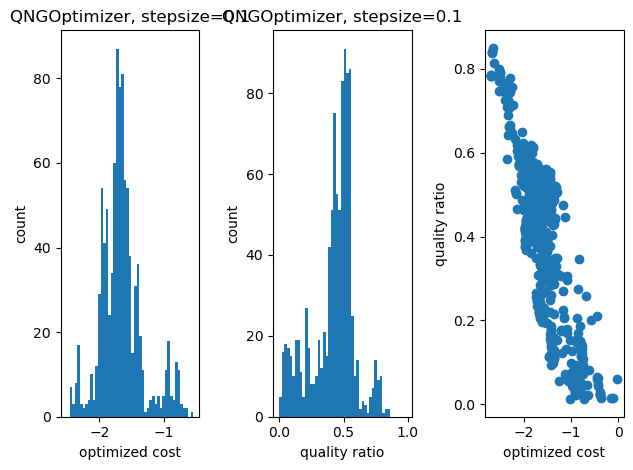

In [ ]:
(qng_opt_costs,qng_opt_quality,qng_opt_asym) = calc_plot_data(qng_opt_params)
plot_opt_data(qng_opt_costs,qng_opt_quality,"QNGOptimizer, stepsize=0.1")

In [ ]:
qngmom09_opt_params = []
start_momentum = 0.9
for init_params in tqdm(init_params_array):
    optimizer = qml.MomentumOptimizer(momentum = start_momentum, stepsize = step_size)
    params = init_params
    best_cost = 100
    cost_counter = 0
    prev_step = params * 0
    for i in range(steps):
        prev_params = params
        opt = qml.QNGOptimizer(stepsize = step_size)
        params = opt.step(cost_function, params) + start_momentum * prev_step
        prev_step = params - prev_params
        cur_cost = cost_function(params)
        if(abs(best_cost - cur_cost) < cost_tolerance):
            cost_counter += 1
            if(cost_counter > cost_tolerance_count):
                break
        else:
            cost_counter = 0
        if(best_cost > cur_cost):
            best_cost = cur_cost
    qngmom09_opt_params.append(params)

100%|██████████| 1000/1000 [5:41:25<00:00, 20.49s/it] 


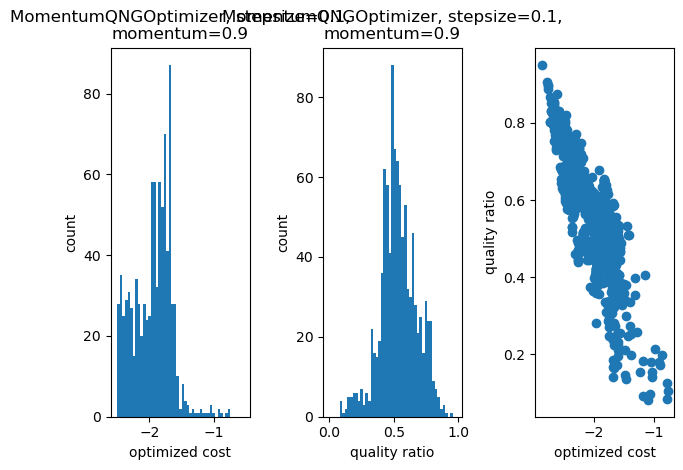

In [ ]:
(qngmom09_opt_costs,qngmom09_opt_quality,qngmom09_opt_asym) = calc_plot_data(qngmom09_opt_params)
plot_opt_data(qngmom09_opt_costs,qngmom09_opt_quality,"MomentumQNGOptimizer, stepsize=0.1,\nmomentum=0.9")

In [ ]:
qngmom07_opt_params = []
start_momentum = 0.7
for init_params in tqdm(init_params_array):
    optimizer = qml.MomentumOptimizer(momentum = start_momentum, stepsize = step_size)
    params = init_params
    best_cost = 100
    cost_counter = 0
    prev_step = params * 0
    for i in range(steps):
        prev_params = params
        opt = qml.QNGOptimizer(stepsize = step_size)
        params = opt.step(cost_function, params) + start_momentum * prev_step
        prev_step = params - prev_params
        cur_cost = cost_function(params)
        if(abs(best_cost - cur_cost) < cost_tolerance):
            cost_counter += 1
            if(cost_counter > cost_tolerance_count):
                break
        else:
            cost_counter = 0
        if(best_cost > cur_cost):
            best_cost = cur_cost
    qngmom07_opt_params.append(params)

100%|██████████| 1000/1000 [2:15:13<00:00,  8.11s/it] 


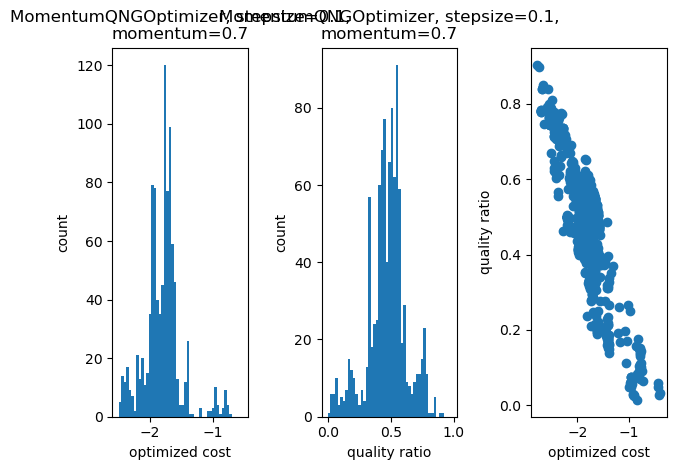

In [ ]:
(qngmom07_opt_costs,qngmom07_opt_quality,qngmom07_opt_asym) = calc_plot_data(qngmom07_opt_params)
plot_opt_data(qngmom07_opt_costs,qngmom07_opt_quality,"MomentumQNGOptimizer, stepsize=0.1,\nmomentum=0.7")

In [ ]:
#dev = qml.device("qulacs.simulator", wires=wires)
#dev = qml.device("default.qubit", wires=wires)
dev = qml.device("lightning.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

def quality_ratio(params):
    probs = probability_circuit(params[0], params[1])
    return probs[6]+probs[10]

def asymmetry_ratio(params):
    probs = probability_circuit(params[0], params[1])
    return probs[6]/probs[10]

In [ ]:
def calc_plot_data(params_array):
    opt_costs = []
    opt_quality = []
    opt_asym = []
    for params in params_array:
        opt_costs.append(cost_function(params))
        opt_quality.append(quality_ratio(params))
        opt_asym.append(asymmetry_ratio(params))
    return (opt_costs,opt_quality,opt_asym)

In [ ]:
mom09_opt_params = []
start_momentum = 0.9
for init_params in tqdm(init_params_array):
    optimizer = qml.MomentumOptimizer(momentum = start_momentum, stepsize = step_size)
    params = init_params
    best_cost = 100
    cost_counter = 0
    for i in range(steps):
        params = optimizer.step(cost_function, params)
        cur_cost = cost_function(params)
        if(abs(best_cost - cur_cost) < cost_tolerance):
            cost_counter += 1
            if(cost_counter > cost_tolerance_count):
                break
        else:
            cost_counter = 0
        if(best_cost > cur_cost):
            best_cost = cur_cost
    mom09_opt_params.append(params)

100%|██████████| 1000/1000 [1:37:32<00:00,  5.85s/it]


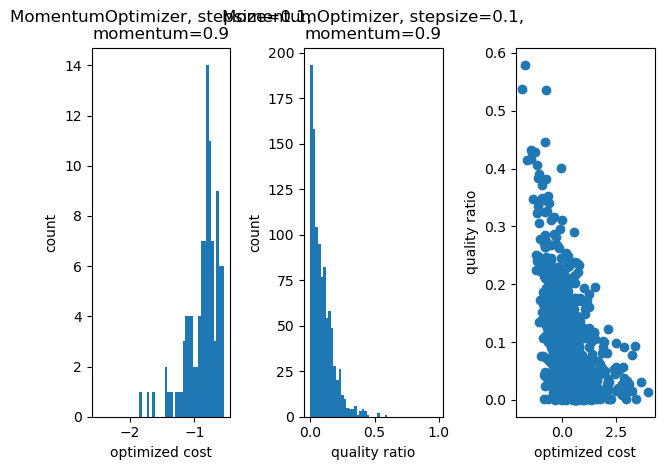

In [ ]:
(mom09_opt_costs,mom09_opt_quality,mom09_opt_asym) = calc_plot_data(mom09_opt_params)
plot_opt_data(mom09_opt_costs,mom09_opt_quality,"MomentumOptimizer, stepsize=0.1,\nmomentum=0.9")

In [ ]:
mom07_opt_params = []
start_momentum = 0.7
for init_params in tqdm(init_params_array):
    optimizer = qml.MomentumOptimizer(momentum = start_momentum, stepsize = step_size)
    params = init_params
    best_cost = 100
    cost_counter = 0
    for i in range(steps):
        params = optimizer.step(cost_function, params)
        cur_cost = cost_function(params)
        if(abs(best_cost - cur_cost) < cost_tolerance):
            cost_counter += 1
            if(cost_counter > cost_tolerance_count):
                break
        else:
            cost_counter = 0
        if(best_cost > cur_cost):
            best_cost = cur_cost
    mom07_opt_params.append(params)

100%|██████████| 1000/1000 [1:25:20<00:00,  5.12s/it]


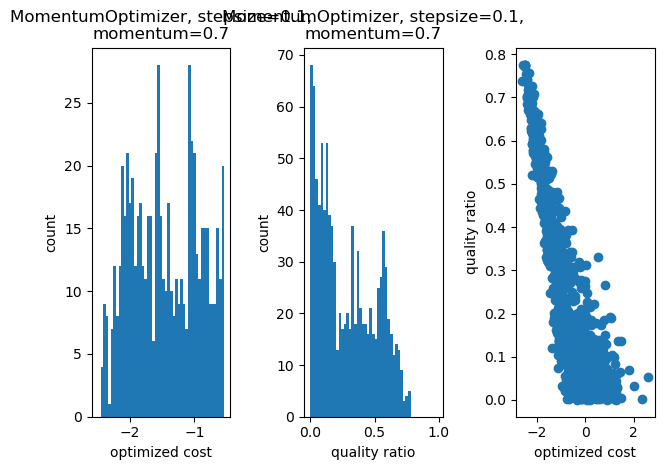

In [ ]:
(mom07_opt_costs,mom07_opt_quality,mom07_opt_asym) = calc_plot_data(mom07_opt_params)
plot_opt_data(mom07_opt_costs,mom07_opt_quality,"MomentumOptimizer, stepsize=0.1,\nmomentum=0.7")

In [ ]:
adam_opt_params = []
for init_params in tqdm(init_params_array):
    optimizer = qml.AdamOptimizer(stepsize = step_size)
    params = init_params
    best_cost = 100
    cost_counter = 0
    for i in range(steps):
        params = optimizer.step(cost_function, params)
        cur_cost = cost_function(params)
        if(abs(best_cost - cur_cost) < cost_tolerance):
            cost_counter += 1
            if(cost_counter > cost_tolerance_count):
                break
        else:
            cost_counter = 0
        if(best_cost > cur_cost):
            best_cost = cur_cost
    adam_opt_params.append(params)

100%|██████████| 1000/1000 [14:32<00:00,  1.15it/s]


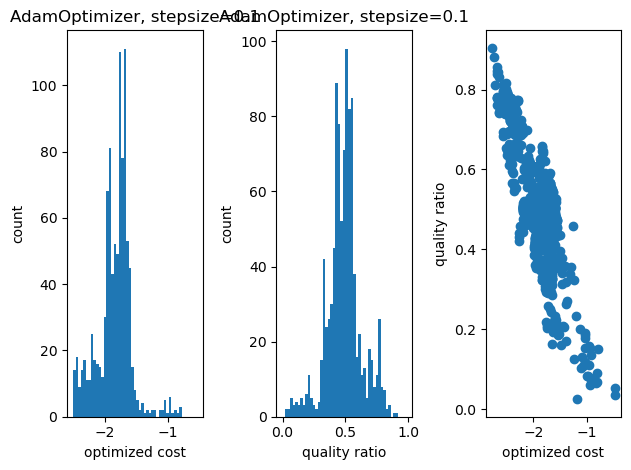

In [ ]:
(adam_opt_costs,adam_opt_quality,adam_opt_asym) = calc_plot_data(adam_opt_params)
plot_opt_data(adam_opt_costs,adam_opt_quality,"AdamOptimizer, stepsize=0.1")

In [ ]:
print(probability_circuit(adam_opt_params[1][0], adam_opt_params[1][1]))

[0.00040257 0.01998386 0.01590158 0.04056612 0.00740209 0.01917259
 0.23389975 0.02218425 0.00740209 0.01917259 0.23389975 0.02218425
 0.04990601 0.13819518 0.12407359 0.04565374]


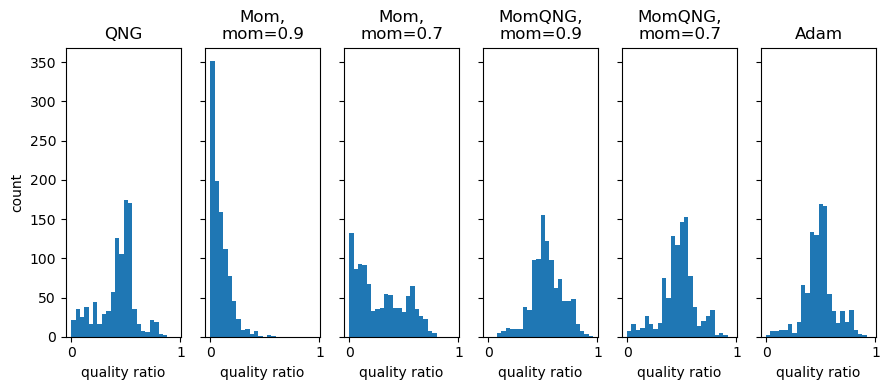

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(9, 4), sharey=True, tight_layout=False)

# We can set the number of bins with the *bins* keyword argument.
n_bins = 10
quality_bins = [i*0.04 for i in range(25)]
axs[0].hist(qng_opt_quality, bins=quality_bins)
axs[1].hist(mom09_opt_quality, bins=quality_bins)
axs[2].hist(mom07_opt_quality, bins=quality_bins)
axs[3].hist(qngmom09_opt_quality, bins=quality_bins)
axs[4].hist(qngmom07_opt_quality, bins=quality_bins)
axs[5].hist(adam_opt_quality, bins=quality_bins)

axs[0].set_xlabel("quality ratio")
axs[0].set_ylabel("count")
axs[1].set_xlabel("quality ratio")
#axs[1].set_ylabel("count")
axs[2].set_xlabel("quality ratio")
#axs[2].set_ylabel("count")
axs[3].set_xlabel("quality ratio")
#axs[3].set_ylabel("count")
axs[4].set_xlabel("quality ratio")
#axs[4].set_ylabel("count")
axs[5].set_xlabel("quality ratio")
#axs[5].set_ylabel("count")
axs[0].set_title("QNG")
axs[1].set_title("Mom,\nmom=0.9")
axs[2].set_title("Mom,\nmom=0.7")
axs[3].set_title("MomQNG,\nmom=0.9")
axs[4].set_title("MomQNG,\nmom=0.7")
axs[5].set_title("Adam")

plt.show()

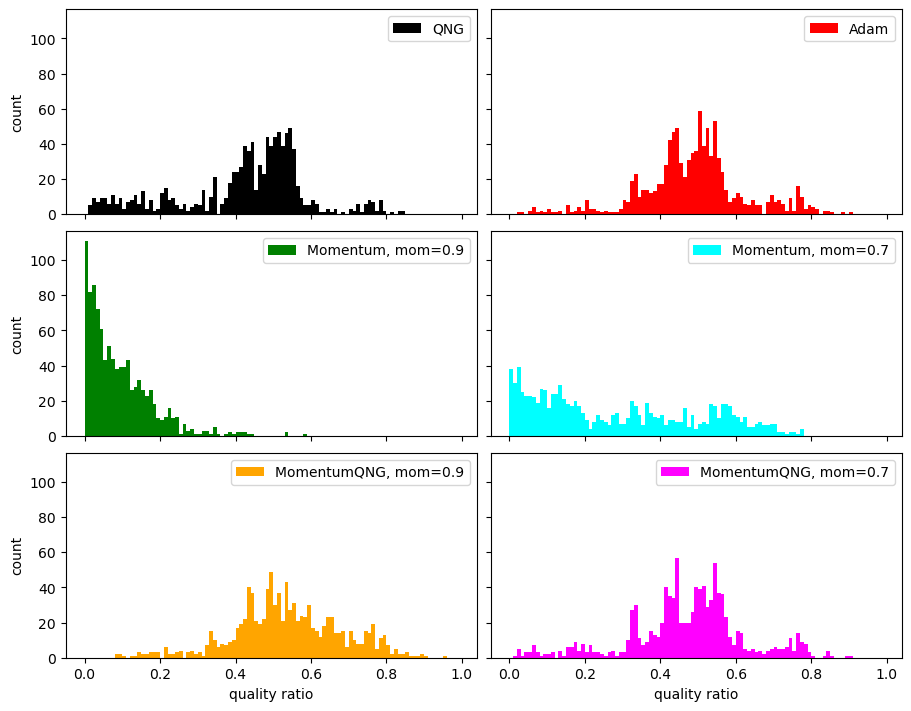

In [ ]:
fig = plt.figure(figsize=(9, 7), layout="constrained")
axs = fig.subplots(3, 2, sharex=True, sharey=True)
#fig, axs = plt.subplots(1, 6, sharey=True, tight_layout=False)

# We can set the number of bins with the *bins* keyword argument.
quality_bins = [i*0.01 for i in range(100)]
axs[0][0].hist(qng_opt_quality, bins=quality_bins,label="QNG", color='black')
axs[0][1].hist(adam_opt_quality, bins=quality_bins,label="Adam", color='red')
axs[1][0].hist(mom09_opt_quality, bins=quality_bins,label="Momentum, mom=0.9", color='green')
axs[1][1].hist(mom07_opt_quality, bins=quality_bins,label="Momentum, mom=0.7", color='cyan')
axs[2][0].hist(qngmom09_opt_quality, bins=quality_bins,label="MomentumQNG, mom=0.9", color='orange')
axs[2][1].hist(qngmom07_opt_quality, bins=quality_bins,label="MomentumQNG, mom=0.7", color='magenta')

axs[0][0].set_ylabel("count")
axs[1][0].set_ylabel("count")
axs[2][0].set_ylabel("count")
axs[2][0].set_xlabel("quality ratio")
axs[2][1].set_xlabel("quality ratio")

axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()
axs[2][0].legend()
axs[2][1].legend()

plt.show()

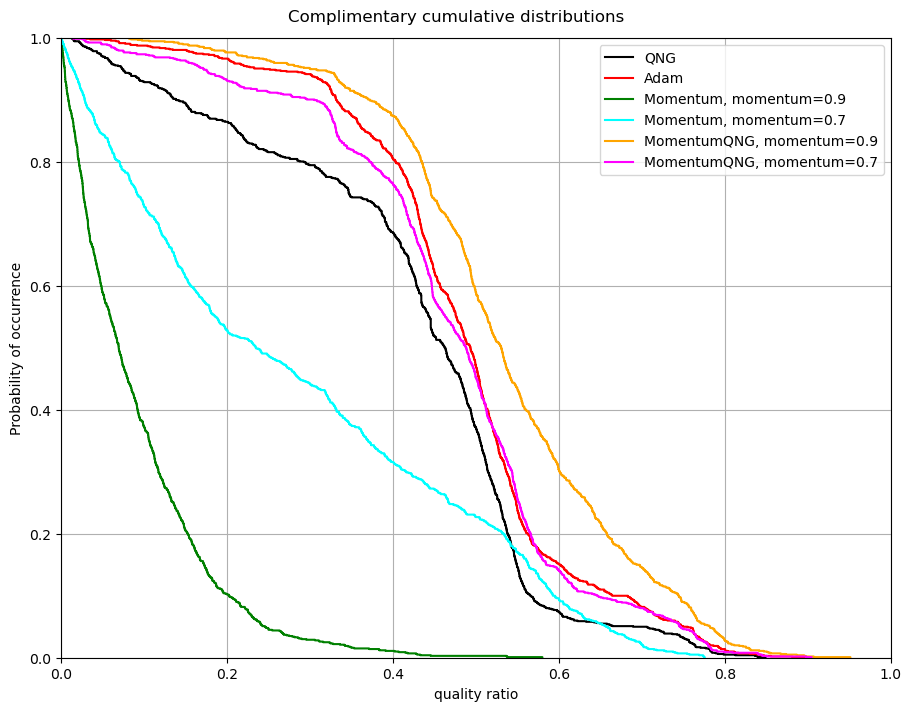

In [ ]:
fig = plt.figure(figsize=(9, 7), layout="constrained")
axs = fig.subplots(1, 1, sharex=True, sharey=True)

# Cumulative distributions.
axs.ecdf(qng_opt_quality,complementary=True, label="QNG", color='black')
axs.ecdf(adam_opt_quality, complementary=True,label="Adam", color='red')
axs.ecdf(mom09_opt_quality,complementary=True, label="Momentum, momentum=0.9", color='green')
axs.ecdf(mom07_opt_quality, complementary=True,label="Momentum, momentum=0.7", color='cyan')
axs.ecdf(qngmom09_opt_quality, complementary=True,label="MomentumQNG, momentum=0.9", color='orange')
axs.ecdf(qngmom07_opt_quality, complementary=True,label="MomentumQNG, momentum=0.7", color='magenta')


# Label the figure.
fig.suptitle("Complimentary cumulative distributions")

axs.grid(True)
axs.legend()
axs.set_xlabel("quality ratio")
axs.set_ylabel("Probability of occurrence")
axs.label_outer()
axs.set_xlim(0.0, 1)
plt.show()

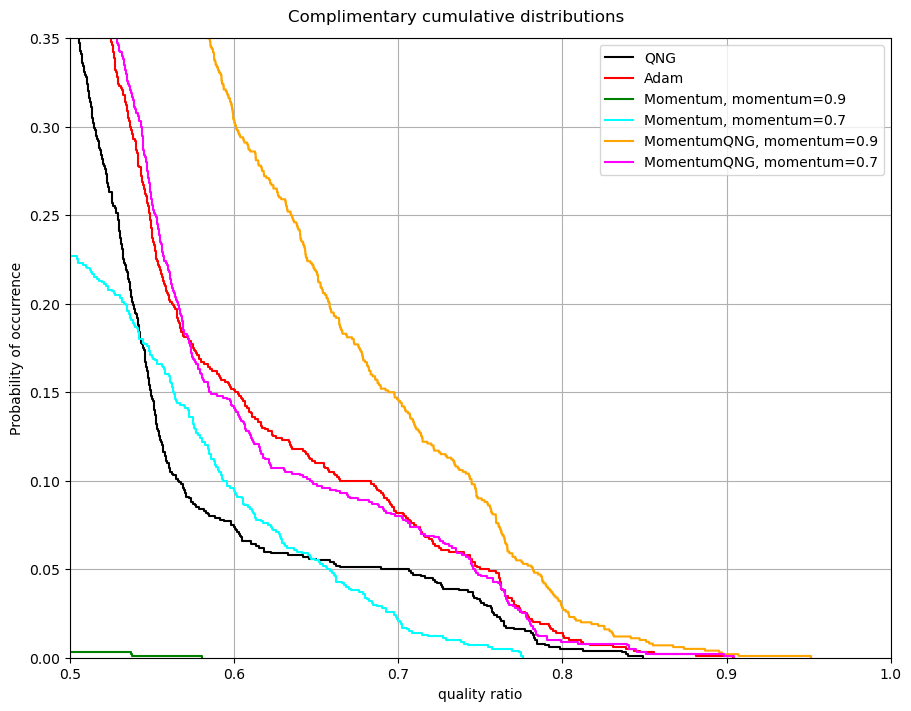

In [ ]:
fig = plt.figure(figsize=(9, 7), layout="constrained")
axs = fig.subplots(1, 1, sharex=True, sharey=True)

# Cumulative distributions.
axs.ecdf(qng_opt_quality,complementary=True, label="QNG", color='black')
axs.ecdf(adam_opt_quality, complementary=True,label="Adam", color='red')
axs.ecdf(mom09_opt_quality,complementary=True, label="Momentum, momentum=0.9", color='green')
axs.ecdf(mom07_opt_quality, complementary=True,label="Momentum, momentum=0.7", color='cyan')
axs.ecdf(qngmom09_opt_quality, complementary=True,label="MomentumQNG, momentum=0.9", color='orange')
axs.ecdf(qngmom07_opt_quality, complementary=True,label="MomentumQNG, momentum=0.7", color='magenta')


# Label the figure.
fig.suptitle("Complimentary cumulative distributions")

axs.grid(True)
axs.legend()
axs.set_xlabel("quality ratio")
axs.set_ylabel("Probability of occurrence")
axs.label_outer()
axs.set_xlim(0.5, 1.0)
axs.set_ylim(0, 0.35)
plt.show()

In [ ]:
with open("quality_depth="+str(depth)+"_19_07_2024.dat", "w") as file:
    for i in range(len(qng_opt_quality)):
        print(i,qng_opt_quality[i],mom09_opt_quality[i],mom07_opt_quality[i],qngmom09_opt_quality[i],qngmom07_opt_quality[i],adam_opt_quality[i],file=file)

with open("costs_depth="+str(depth)+"_19_07_2024.dat", "w") as file:
    for i in range(len(qng_opt_quality)):
        print(i,qng_opt_costs[i],mom09_opt_costs[i],mom07_opt_costs[i],qngmom09_opt_costs[i],qngmom07_opt_costs[i],adam_opt_costs[i],file=file)

with open("asym_depth="+str(depth)+"_19_07_2024.dat", "w") as file:
    for i in range(len(qng_opt_quality)):
        print(i,qng_opt_asym[i],mom09_opt_asym[i],mom07_opt_asym[i],qngmom09_opt_asym[i],qngmom07_opt_asym[i],adam_opt_asym[i],file=file)

with open("params_depth="+str(depth)+"_19_07_2024.dat", "w") as file:
    for i in range(len(qng_opt_quality)):
        print(i,qng_opt_params[i][0],qng_opt_params[i][1],mom09_opt_params[i][0],mom09_opt_params[i][1],mom07_opt_params[i][0],mom07_opt_params[i][1],qngmom09_opt_params[i][0],qngmom09_opt_params[i][1],qngmom07_opt_params[i][0],qngmom07_opt_params[i][1],adam_opt_params[i][0],adam_opt_params[i][1],file=file)
